# Model Selection
1. Triple Target Barrier for Returns
1. Combines Alphas (text, macroeconomic variables, formulaic alphas)
1. Purged Cross Fold Validation
1. Grid Search
1. Feature Importance
1. Train Test Performance

This notebook is mainly for cross validation grid search. The analysis is done in 3b.

In [ ]:
!pip install numpy_ext
!pip install openpyxl

In [1]:
import boto3
import pandas as pd
import glob

import io
import os

from datetime import datetime, date, timedelta

import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from s3 import write_to_s3, read_from_s3, list_s3_contents
from helper import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection._split import _BaseKFold
from lightgbm import LGBMClassifier

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [ ]:
YEARS = 3
START_DATE, END_DATE = get_start_end_dates(YEARS)

In [ ]:
dates = pd.bdate_range(START_DATE, END_DATE)
dates

# Reading In Price

In [2]:
# From Yahoo Finance
price_df_yf = get_price_data_yf(dates)

In [3]:
price_df_investingdotcom = get_price_investingdotcom_data()

In [4]:
# Combine
backtest_dates = pd.DataFrame(pd.bdate_range(START_DATE, END_DATE)).rename(columns={0:"Date"})
price_df_yf = backtest_dates.merge(price_df_yf, on ="Date")
price_df_investingdotcom = backtest_dates.merge(price_df_investingdotcom, on ="Date")
price_df = price_df_investingdotcom.merge(price_df_yf, on="Date")
price_df = price_df.set_index("Date")

In [5]:
# This is for triple barrier method
returns_df = price_df.pct_change().copy()

# Target Triple Barrier Method

In [6]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [10]:
triple_barrier_target_df_21_days_07_factor = triple_barrier(price_df, vertical_barrier = 21, factor=0.7)

# Reading In Alphas

# First, NLP Features
For each dataset:
1. Put to daily series
1. lag by 1 day
1. Aggregate the past 21 days news sentiment
1. Create a variable has_xx_dataset so model knows whether there were news articles or not

In [11]:
nyt_sentiment_chatgpt_final = read_alphas_nyt()
analyst_ratings_processed = read_alphas_analyst()
us_equities_news_dataset_processed = read_alphas_usnews()

In [12]:
from pandas.tseries.offsets import BDay

nyt_sentiment_chatgpt_final["date"] = nyt_sentiment_chatgpt_final["date"] + BDay(1)
analyst_ratings_processed["date"] = analyst_ratings_processed["date"] + BDay(1)
us_equities_news_dataset_processed["date"] = us_equities_news_dataset_processed["date"] + BDay(1)

nyt_sentiment_chatgpt_final["news_count"] = 1
analyst_ratings_processed["news_count"] = 1
us_equities_news_dataset_processed["news_count"] = 1

In [13]:
nyt_sentiment_chatgpt_final = nyt_sentiment_chatgpt_final.groupby(["ticker", "date"]).sum().reset_index()
analyst_ratings_processed = analyst_ratings_processed.groupby(["ticker", "date"]).sum().reset_index()
us_equities_news_dataset_processed = us_equities_news_dataset_processed.groupby(["ticker", "date"]).sum().reset_index()

news_sum_window = 21

In [14]:
nyt_sentiment_chatgpt_final_daily = []

backtest_dates = pd.DataFrame(pd.bdate_range("2009-01-01", "2023-02-10")).rename(columns={0:"date"})

for ticker in nyt_sentiment_chatgpt_final.ticker.unique():
    curr_df = nyt_sentiment_chatgpt_final[nyt_sentiment_chatgpt_final.ticker == ticker].copy()
    # Count news
    curr_df["has_nyt_news"] = 1
    
    # Daily series
    curr_df = backtest_dates.merge(curr_df, how="left", on="date")
    curr_df["ticker"] = ticker
    curr_df.set_index(["date", "ticker"], inplace=True)
    
    curr_df.columns = ["nyt_news_" + c for c in curr_df.columns]
    
    curr_df = curr_df.fillna(0)
    # 21 days
    curr_df = curr_df.rolling(news_sum_window).sum().loc["2010-01-01":].reset_index()
    nyt_sentiment_chatgpt_final_daily.append(curr_df)
nyt_sentiment_chatgpt_final_daily = pd.concat(nyt_sentiment_chatgpt_final_daily)

In [15]:
analyst_ratings_processed_daily = []

backtest_dates = pd.DataFrame(pd.bdate_range("2009-01-01", "2023-02-10")).rename(columns={0:"date"})

for ticker in analyst_ratings_processed.ticker.unique():
    curr_df = analyst_ratings_processed[analyst_ratings_processed.ticker == ticker].copy()
    curr_df["has_analyst_news"] = 1
    curr_df = backtest_dates.merge(curr_df, how="left", on="date")
    curr_df["ticker"] = ticker
    curr_df.set_index(["date", "ticker"], inplace=True)
    
    curr_df.columns = ["analyst_news_" + c for c in curr_df.columns]
    
    curr_df = curr_df.fillna(0)
    curr_df = curr_df.rolling(news_sum_window).sum().loc["2010-01-01":].reset_index()
    analyst_ratings_processed_daily.append(curr_df)
analyst_ratings_processed_daily = pd.concat(analyst_ratings_processed_daily)

In [16]:
us_equities_news_dataset_processed_daily = []

backtest_dates = pd.DataFrame(pd.bdate_range("2009-01-01", "2023-02-10")).rename(columns={0:"date"})

for ticker in us_equities_news_dataset_processed.ticker.unique():
    curr_df = us_equities_news_dataset_processed[us_equities_news_dataset_processed.ticker == ticker].copy()
    curr_df["has_us_news"] = 1
    curr_df = backtest_dates.merge(curr_df, how="left", on="date")
    curr_df["ticker"] = ticker
    curr_df.set_index(["date", "ticker"], inplace=True)
    
    curr_df.columns = ["us_news_" + c for c in curr_df.columns]
    
    curr_df = curr_df.fillna(0)
    curr_df = curr_df.rolling(news_sum_window).sum().loc["2010-01-01":].reset_index()
    us_equities_news_dataset_processed_daily.append(curr_df)
us_equities_news_dataset_processed_daily = pd.concat(us_equities_news_dataset_processed_daily)

# Read in Formulaic Alphas

In [17]:
all_traditional_alphas_df = get_alpha_data_yf(dates, START_DATE, END_DATE)

  0%|          | 0/731 [00:00<?, ?it/s]

In [19]:
triple_barrier_target_df_final = triple_barrier_target_df_21_days_07_factor.reset_index().melt(id_vars="Date").rename(columns={"Date":"date"})

# This model_number just assigns a number 0 to 20 for each day
# We will just select one, e.g model_number == 0. Reduce amount of data for cross validation
triple_barrier_target_df_final["model_number"] = triple_barrier_target_df_final.index
triple_barrier_target_df_final["model_number"] = triple_barrier_target_df_final["model_number"] % 21
triple_barrier_target_df_final = triple_barrier_target_df_final.dropna()
triple_barrier_target_df_final.columns = ["date", "ticker", "target", "model_number"]
triple_barrier_target_df_final = triple_barrier_target_df_final[triple_barrier_target_df_final.ticker.isin(all_traditional_alphas_df.ticker.unique())]

# Read in MacroEconomic Data

In [20]:
PMI_final = get_macroeconomic_data_pmi(backtest_dates)

In [21]:
REAL_GDP_final = get_macroeconomic_data_real_gdp(backtest_dates)

In [22]:
T10Y_Inflation_Breakeven_final = get_macroeconomic_data_t10y_inflation_breakeven(backtest_dates)
T10Y_Inflation_Breakeven_final.tail()

,date,Inflation_Breakeven_Level,Inflation_Breakeven_1M_Change
3677,2023-02-07,2.25,0.04
3678,2023-02-08,2.31,0.09
3679,2023-02-09,2.34,0.10
3680,2023-02-10,2.33,0.10
3681,2023-02-13,2.33,0.12


<AxesSubplot:xlabel='date'>

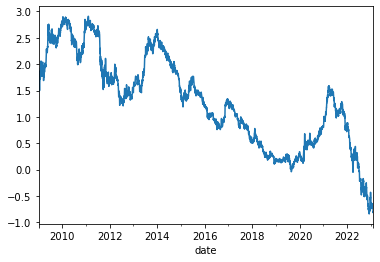

In [23]:
T10Y_minus_2Y = get_macroeconomic_data_t10y_minus_2y(backtest_dates)
T10Y_minus_2Y["T10Y_minus_2Y"].plot()

In [24]:
all_macro_economic_alphas = T10Y_minus_2Y.merge(T10Y_Inflation_Breakeven_final).merge(REAL_GDP_final).merge(PMI_final).dropna()

In [26]:
training_test_df = triple_barrier_target_df_final.merge(all_traditional_alphas_df, how="left", on = ["date", "ticker"]).merge(all_macro_economic_alphas, how="left", on=["date"])

In [27]:
training_test_df = training_test_df.merge(nyt_sentiment_chatgpt_final_daily, how="left", on = ["date", "ticker"])
training_test_df = training_test_df.merge(analyst_ratings_processed_daily, how="left", on = ["date", "ticker"])
training_test_df = training_test_df.merge(us_equities_news_dataset_processed_daily, how="left", on = ["date", "ticker"])
lst = []
for ticker in tqdm(training_test_df.ticker.unique()):
    curr_df = training_test_df[training_test_df.ticker == ticker].ffill(limit=2).copy()
    lst.append(curr_df)
training_test_df = pd.concat(lst)

  0%|          | 0/706 [00:00<?, ?it/s]

In [28]:
fill_0s = ['nyt_news_ChatGPT_sentiment', 'nyt_news_finbert_positive',
       'nyt_news_finbert_negative', 'nyt_news_finbert_neutral',
       'nyt_news_lmd_negative_words_count',
       'nyt_news_lmd_positive_words_count',
       'nyt_news_lmd_uncertain_words_count',
       'nyt_news_lmd_litigious_words_count',
       'nyt_news_lmd_strong_modal_words_count',
       'nyt_news_lmd_weak_modal_words_count', 'nyt_news_word_count',
       'nyt_news_news_count', 'nyt_news_has_nyt_news',
       'analyst_news_lmd_negative_words_count',
       'analyst_news_lmd_positive_words_count',
       'analyst_news_lmd_uncertain_words_count',
       'analyst_news_lmd_litigious_words_count',
       'analyst_news_lmd_strong_modal_words_count',
       'analyst_news_lmd_weak_modal_words_count',
       'analyst_news_finbert_positive', 'analyst_news_finbert_negative',
       'analyst_news_finbert_neutral', 'analyst_news_news_count',
       'analyst_news_has_analyst_news', 'us_news_lmd_negative_words_count',
       'us_news_lmd_positive_words_count', 'us_news_lmd_uncertain_words_count',
       'us_news_lmd_litigious_words_count',
       'us_news_lmd_strong_modal_words_count',
       'us_news_lmd_weak_modal_words_count', 'us_news_finbert_positive',
       'us_news_finbert_negative', 'us_news_finbert_neutral',
       'us_news_news_count', 'us_news_has_us_news']
training_test_df[fill_0s] = training_test_df[fill_0s].fillna(0)

In [29]:
training_test_df.dropna(thresh=50, inplace=True)

In [30]:
write_to_s3(training_test_df, "train_test/train_test_21_days.csv")

# Begin ML

In [ ]:
TRAIN_PROPORTION = .8
TRAIN_END_DATE = END_DATE - timedelta(days=365 * YEARS * TRAIN_PROPORTION)
TEST_START_DATE = TRAIN_END_DATE 

In [32]:
training_test_df = read_from_s3("train_test/train_test_21_days.csv")
training_test_df.date = pd.to_datetime(training_test_df.date)
# Select any model_number, 1/21 of the original data
# So that cross validation will actually finish (if not, it will take days)
training_df = training_test_df[(training_test_df.date < str(TRAIN_END_DATE)) & (training_test_df.model_number == 0)].reset_index(drop=True).copy()
test_df = training_test_df[(training_test_df.date >= str(TEST_START_DATE))  & (training_test_df.model_number == 0)].reset_index(drop=True).copy()

In [34]:
x_vals = [c for c in training_df.columns if c not in ["date", "ticker", "target", "model_number"]]

In [37]:
training_df.reset_index(drop=True, inplace=True)

# Purged Cross Fold Validation

In [ ]:
train_dates = pd.date_range(START_DATE, TRAIN_END_DATE + timedelta(1))

In [ ]:
folds = np.array_split(train_dates, 5)

In [38]:
fold_1 = training_df[(training_df.date <= folds[0][-1])].index.values
fold_2 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_3 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_4 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_5 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values

In [39]:
# Construct CV
cv_folds = [(np.concatenate([fold_2, fold_3, fold_4, fold_5]), fold_1),
(np.concatenate([fold_1, fold_3, fold_4, fold_5]), fold_2),
(np.concatenate([fold_1, fold_2, fold_4, fold_5]), fold_3),
(np.concatenate([fold_1, fold_2, fold_3, fold_5]), fold_4),
(np.concatenate([fold_1, fold_2, fold_3, fold_4]), fold_5)]

# Grid Search

In [39]:
estimator = {
        'RandomForestClassifier': RandomForestClassifier(),
        'ExtraTreesClassifier': ExtraTreesClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),\
                                                 n_estimators = 10),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'SVC': SVC(probability=True),
        'LGBMClassifier': LGBMClassifier()
        }

param_grid = {
        'RandomForestClassifier': {'max_features':[None],'n_estimators':[10, 20],'max_depth':[30, None],\
                                   'min_samples_split':[2, 10],'criterion':['entropy'],\
                                   'min_samples_leaf':[3, 10]},
        'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[10, 20],'max_depth':[30, None],\
                                 'min_samples_split':[2, 10],'criterion':['entropy'],\
                                 'min_samples_leaf':[3, 10]},
        'AdaBoostClassifier': {"base_estimator__criterion" : ["entropy"],\
                               "base_estimator__max_depth": [30, None],\
                               "base_estimator__min_samples_leaf" : [3, 10],\
                               "base_estimator__min_samples_split" : [2, 10],\
                               "base_estimator__max_features" : [None]},
        'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[10, 20],'max_depth':[30, None],\
                                       'min_samples_split':[2, 10],'min_samples_leaf':[3, 10],\
                                       'learning_rate':[0.1],'subsample':[1.0]},
        'SVC': [{'kernel':['rbf'],'gamma':['scale', 'auto'],'C':[1, 0.5]}],
        'LGBMClassifier':{"colsample_bytree":[0.75, 1], "subsample":[0.75, 1], "max_depth":[-1, 30]}
        }

In [40]:
X_train = training_df[training_df.model_number == 0].copy()
y_train = X_train.target.copy()
X_train = X_train.drop(columns="target")
X_train[x_vals] = X_train[x_vals].astype(float)

X_test = test_df.copy()
y_test = X_test.target.copy()
X_test = X_test.drop(columns="target")
X_test[x_vals] = X_test[x_vals].astype(float)

In [ ]:
store_grid_searches = {}

for est_name in ["LGBMClassifier", "GradientBoostingClassifier", "AdaBoostClassifier",
                "ExtraTreesClassifier", "RandomForestClassifier", "SVC"]:
    print(f"########### FITTING FOR {est_name} NOW ###########")
    clf = GridSearchCV(estimator[est_name], param_grid[est_name], scoring="accuracy", cv=cv_folds, verbose=3, n_jobs=1)
    clf.fit(X_train[x_vals], y_train)
    
    params_score = pd.DataFrame(clf.cv_results_["params"])
    params_score["score"] = clf.cv_results_["mean_test_score"]
    params_score["estimator"] = est_name
    params_score.sort_values("score", inplace=True, ascending=False)
    params_score.to_csv(f"../results/{est_name}_optimization_month_pred.csv")
    
    store_grid_searches[est_name] = clf

########### FITTING FOR LGBMClassifier NOW ###########
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.75, max_depth=-1, subsample=0.75;, score=0.426 total time=   1.4s
[CV 2/5] END colsample_bytree=0.75, max_depth=-1, subsample=0.75;, score=0.372 total time=   1.4s
[CV 3/5] END colsample_bytree=0.75, max_depth=-1, subsample=0.75;, score=0.410 total time=   1.3s
[CV 4/5] END colsample_bytree=0.75, max_depth=-1, subsample=0.75;, score=0.431 total time=   1.3s
[CV 5/5] END colsample_bytree=0.75, max_depth=-1, subsample=0.75;, score=0.419 total time=   1.3s
[CV 1/5] END colsample_bytree=0.75, max_depth=-1, subsample=1;, score=0.426 total time=   1.3s
[CV 2/5] END colsample_bytree=0.75, max_depth=-1, subsample=1;, score=0.372 total time=   1.4s
[CV 3/5] END colsample_bytree=0.75, max_depth=-1, subsample=1;, score=0.410 total time=   1.4s
[CV 4/5] END colsample_bytree=0.75, max_depth=-1, subsample=1;, score=0.431 total time=   1.4s
[CV 5/5] END co

[CV 1/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=20, subsample=1.0;, score=0.376 total time= 5.8min
[CV 2/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=20, subsample=1.0;, score=0.358 total time= 5.9min
[CV 3/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=20, subsample=1.0;, score=0.383 total time= 6.2min
[CV 4/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=20, subsample=1.0;, score=0.415 total time= 5.8min
[CV 5/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=20, subsample=1.0;, score=0.391 total time= 6.1min
[CV 1/5] END learning_rate=0.1, max_depth=30, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10, subsample=1.0;, scor

[CV 4/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10, subsample=1.0;, score=0.415 total time= 2.8min
[CV 5/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10, subsample=1.0;, score=0.395 total time= 3.0min
[CV 1/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20, subsample=1.0;, score=0.382 total time= 5.9min
[CV 2/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20, subsample=1.0;, score=0.359 total time= 6.0min
[CV 3/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20, subsample=1.0;, score=0.391 total time= 6.2min
[CV 4/5] END learning_rate=0.1, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20, sub

C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.380 total time= 1.5min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.358 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.366 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.378 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.365 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.374 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.368 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.370 total time= 2.0min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.381 total time= 1.8min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.372 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.360 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.346 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.356 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.377 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.376 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.373 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.353 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.364 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.371 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=30, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.361 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.376 total time= 1.5min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.362 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.367 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.382 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2;, score=0.365 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.366 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.369 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.363 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.375 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10;, score=0.359 total time= 1.6min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.361 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.351 total time= 1.8min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.363 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.381 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=2;, score=0.375 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.359 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.364 total time= 1.7min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.364 total time= 2.0min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.370 total time= 2.1min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__max_features=None, base_estimator__min_samples_leaf=10, base_estimator__min_samples_split=10;, score=0.365 total time= 1.9min


C:\Users\Nicklaus\anaconda3\envs\python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


########### FITTING FOR SVC NOW ###########
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.422 total time=26.7min
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.464 total time=27.0min
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.381 total time=33.8min
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.420 total time=35.3min
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.382 total time=35.9min
[CV 1/5] END ......C=1, gamma=auto, kernel=rbf;, score=0.422 total time=133.4min
[CV 2/5] END ......C=1, gamma=auto, kernel=rbf;, score=0.464 total time=131.5min
[CV 3/5] END ......C=1, gamma=auto, kernel=rbf;, score=0.381 total time=130.2min
[CV 4/5] END ......C=1, gamma=auto, kernel=rbf;, score=0.420 total time=138.5min


# Feature Importance

In [35]:
direction_model = LGBMClassifier()
direction_model.fit(X_train[x_vals], y_train)

LGBMClassifier()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

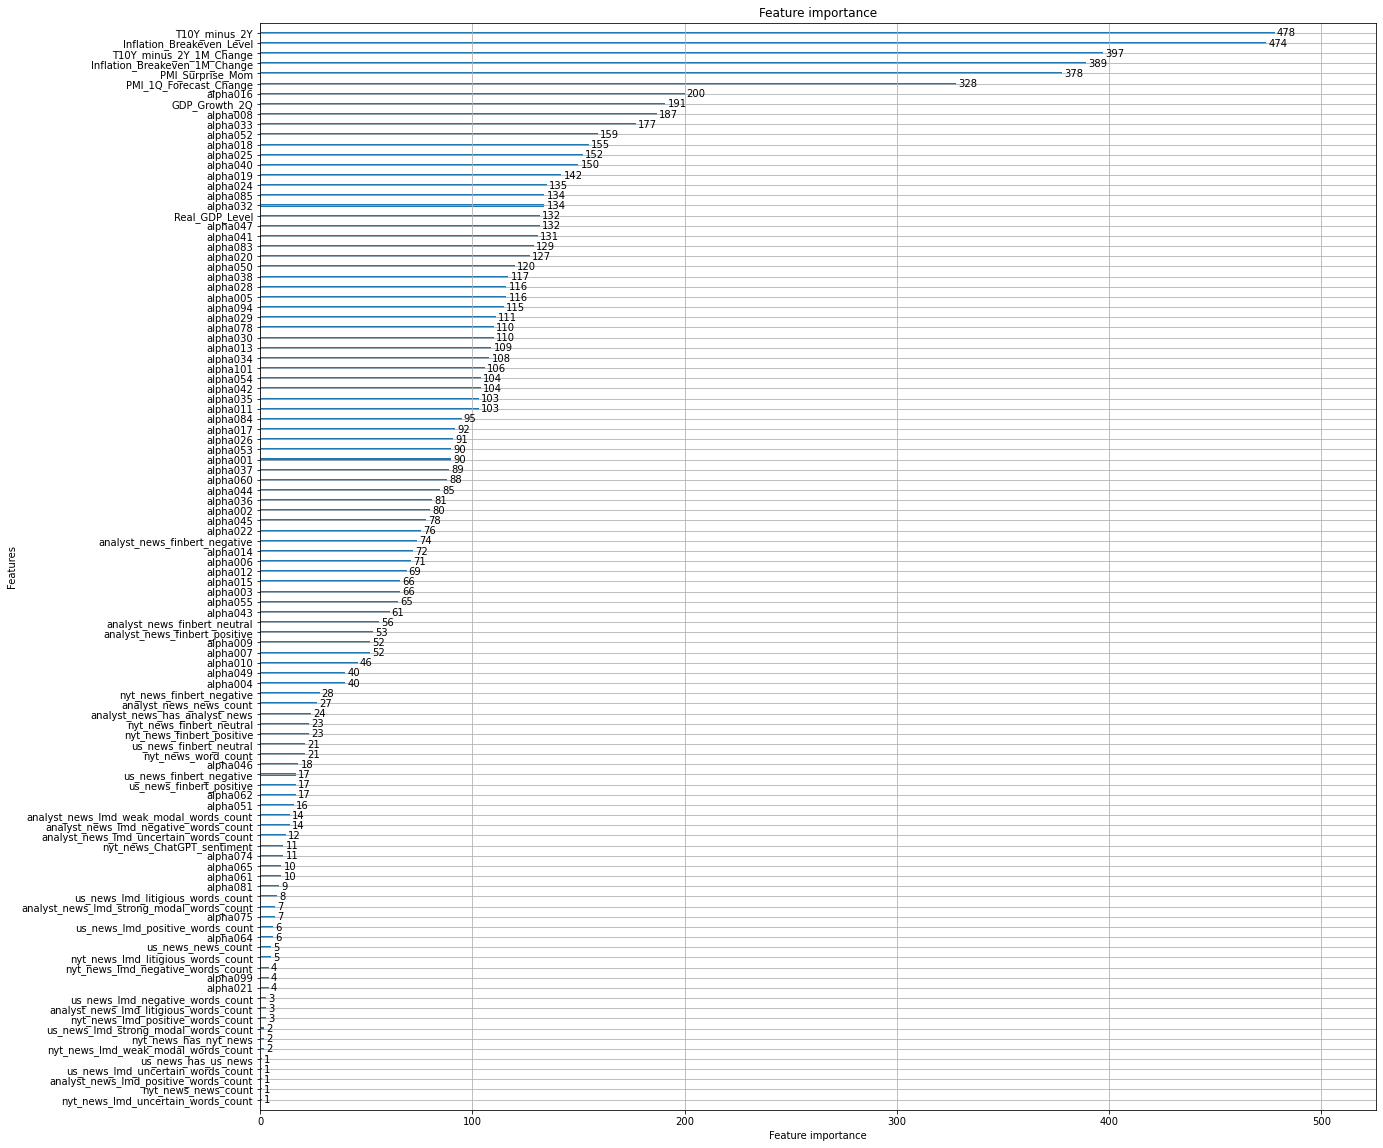

In [83]:
from lightgbm import plot_importance
plot_importance(direction_model, figsize=(20,20))

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
train_preds = direction_model.predict(X_train[x_vals])

# Train Test Performance

Confusion matrix, without normalization
[[ 9948  1125  5402]
 [ 2107  5340  5724]
 [ 2689  1119 17300]]


Text(0.5, 1.0, 'Confusion Matrix (Train)')

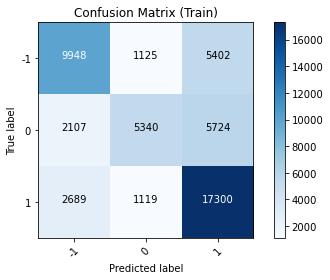

In [75]:
import seaborn as sns

cm = confusion_matrix(y_train, train_preds)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Train)")

In [78]:
from sklearn.metrics import classification_report
print("Classification Report for Train")
print(classification_report(y_train, train_preds))

Classification Report for Train
              precision    recall  f1-score   support

        -1.0       0.67      0.60      0.64     16475
         0.0       0.70      0.41      0.51     13171
         1.0       0.61      0.82      0.70     21108

    accuracy                           0.64     50754
   macro avg       0.66      0.61      0.62     50754
weighted avg       0.65      0.64      0.63     50754



In [79]:
print("Classification Report for Test")
print(classification_report(y_test, preds_test))

Classification Report for Test
              precision    recall  f1-score   support

        -1.0       0.37      0.21      0.27      4651
         0.0       0.40      0.19      0.26      3671
         1.0       0.40      0.70      0.51      5519

    accuracy                           0.40     13841
   macro avg       0.39      0.36      0.35     13841
weighted avg       0.39      0.40      0.36     13841



In [74]:
y_train.value_counts()

 1.0    21108
-1.0    16475
 0.0    13171
Name: target, dtype: int64

In [36]:
preds_test = direction_model.predict(X_test[x_vals])

Confusion matrix, without normalization
[[ 959  495 3197]
 [ 489  703 2479]
 [1116  557 3846]]


Text(0.5, 1.0, 'Confusion Matrix (Test)')

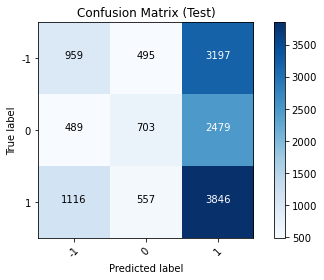

In [76]:
import seaborn as sns

cm = confusion_matrix(y_test, preds_test)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Test)")